In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as integ
import matplotlib.pyplot as plt

def f(x,y,a,b):
    return np.exp(-(((x-a)/a)**2+((y-b)/b)**2)/2)/(a*b*2*np.pi)
#y=np.linspace(-100,100,10000)
#plt.plot(y,integ.quad(f, -np.inf, np.inf,args=(3,4,y)))
#x,y=np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))
#plt.contourf(x,y,f(x,y,10,4))
#plt.show()
#res,err=integ.quad(f, -np.inf, np.inf,args=(0,3,4))
#print(res*np.sqrt(2*np.pi)*4*np.exp(1/2))
#print(err)
def f2(x,a):
    return np.exp(-(x/a)**2/2)/(a*np.sqrt(2*np.pi) )
res,err=integ.quad(f2, -100, 100,args=(1,))
#plt.figure(2)
#plt.plot(np.linspace(-20,20,100),f2(np.linspace(-20,20,100),1))
#plt.show()
print(res)
print(err)
def fint(a,b):
    return integ.dblquad(f, -np.inf, np.inf, lambda x: 0, lambda x: np.inf,args=(a,b))
    #return integ.dblquad(f, -np.inf, np.inf, lambda x: 0, lambda x: np.inf,args=(a,b))
    #return integ.quad(lambda a,b,y: integ.quad(f, -np.inf, np.inf,args=(a,b,y)),-np.inf,np.inf,args=(a,b))
    #return integ.quad(f, -np.inf, np.inf,args=(a,b,0))
res,err = fint(3,4)
print(res)
print(err)
#def f(a,b,x):
#    return np.exp(-(((x-a)/b)**2)/2)/(b*np.sqrt(2*np.pi))
#def fint(a,b):
#    return integ.quad(f, -np.inf, np.inf,args=(a,b))
#res,err = fint(3,4)
#res

1.0000000000000002
1.0346447361664605e-12
0.8413447460854371
4.683631640725952e-09


In [6]:
import sympy as sym

a,b,x,y = sym.symbols(" a b x y")
def fsym(a,b,x,y):
    return sym.exp(-(((x-a)/a)**2+((y-b)/b)**2)/2)/(a*b*2*sym.pi)
sym.N(sym.integrate(fsym(3,4,x,0),(x,-sym.oo, sym.oo))*sym.sqrt(sym.pi*2)*4*sym.exp(1/2))

1.00000000000000

characteristic frequency:  9.68245836552


/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


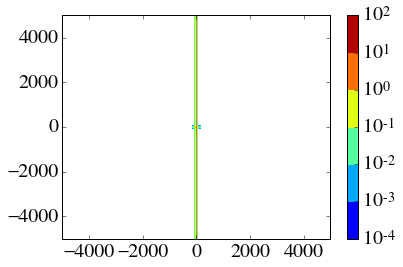

-1000.0 -9.68345836552 -1000.0 -9.68345836552


TypeError: object of type 'float' has no len()

In [4]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as integ
from IPython.core.debugger import Tracer
from matplotlib.colors import LogNorm
import numdifftools as nd
#Tracer()() #this one triggers the debugger
import time

mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=20)
mpl.rc('ytick',labelsize=20)

def sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phib,La,Lb):
# Function to determine the phase sensitivity of the setup
    ## Parameters from inputs ##
    kapa  = kapa*2*np.pi
    kapb  = kapb*2*np.pi
    La    = La/100.
    Lb    = Lb/100.
    phib  = phib*np.pi
    taua  = kta/kapa
    taub  = ktb/kapa
    Del   = delta*kapa
    eps   = x*kapa
    kap1a = kapa * ra                         #\kappa_{1,a} (coupling on the right hand side in mode a)
    kap1b = kapb * rb                         #\kappa_{1,b} (coupling on the right hand side in mode b)
    kap2a = kapa * (1-ra)                     #\kappa_{2,a} (coupling on the left hand side in mode a)
    kap2b = kapb * (1-rb)                     #\kappa_{2,b} (coupling on the left hand side in mode b)

    ka = 2*np.sqrt(ra*(1-ra)*(1-La))*kapa    #k_a (feedback strength in mode a)
    kb = 2*np.sqrt(rb*(1-rb)*(1-Lb))*kapb    #k_b (feedback strength in mode b)
    
    specfreq = np.sqrt(ka**2-(kapa-eps)**2)/np.pi/2.
    print("characteristic frequency: ",specfreq)
    ### EXPRESSIONS ###
    def Ei(nu,t,phi):
        return np.exp(1j*(nu*t+phi))
    def d(nu,t,phi,kap,Del,k): #dpa if Del&phi, dma if -Del&-phi, dmb if Del&-phi, dpb if -Del&phi
        return kap - 1j*(nu+Del) + k*Ei(nu,t,-phi)    
    def Lf(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,eps):#Lab if Del & p is a
        return abs(eps)**2 - d(nu,tp,phip,kapp,Del,kp)*d(nu,tm,-phim,kapm,Del,km)
    def K(nu,t,phi,kap,k,kap1,L):  
        return kap + k*np.cos(phi+nu*t) - kap1*L    
    def albe(nu,t,phi,kap1,kap2,L): #alpha1 if phia,kap1a,kap2a,La 
        return np.sqrt(2*kap1) + np.sqrt(2*kap2*(1-L))*Ei(nu,t,phi)
    def D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps): #Da if Del & p is b
        return np.sqrt(1-L)*Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km,eps)*Ei(nu,tm,phim) +\
        d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap1,kap2,L)*albe(nu,tm,phim,kap2,kap1,L)
    def E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps): #Ea if Del & p is b
        return np.sqrt(L)*(np.sqrt(2*kap2)*d(nu,tp,phip,kapp,-Del,kp)*albe(nu,tm,phim,kap2,kap1,L) +\
        Lf(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km,eps))
    def R(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps): #for Ra p means b
        return albe(nu,tm,phim,kap1,kap2,L)*np.conj(D(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps)) +\
    np.sqrt(2*kap2*L)*np.conj(E(nu,Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1,kap2,L,eps))
    def U(nu,nup,tp,phip,kapp,Del,kp,Lp,kap1p,kap2p,tm,phim,kapm,km,Lm,kap1m,kap2m,eps): #in case of Uab a is p
        return 4*K(-nu,tp,phip,kapp,kp,kap1p,Lp)*K(nu,tm,phim,kapm,km,kap1m,0)*\
    (abs(D(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp,eps))**2+\
     abs(E(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp,eps))**2) +\
    np.conj(albe(-nu,tp,phip,kap2p,kap1p,Lp))*R(nu,-Del,tp,phip,kapp,kp,tm,phim,kapm,km,kap1m,kap2m,Lm,eps)*\
    albe(-nup,tm,phim,kap2m,kap1m,Lm)*np.conj(R(nup,Del,tm,phim,kapm,km,tp,phip,kapp,kp,kap1p,kap2p,Lp,eps))
    
    #Uncertainty of the particle number 
    def uncert(nu,nup,phi,eps):
        uncertval = np.zeros((len(nu),len(nup)))
        for ni in range(0,len(nu)):
            for nj in range(0,len(nup)):
                check = np.real(np.abs(eps)**2*(U(nu[ni,nj],nup[ni,nj],taua,phib+phi,kapa,Del,ka,La,kap1a,kap2a,\
                                         taub,phib,kapb,kb,Lb,kap1b,kap2b,eps)/\
                            (np.abs(Lf(nu[ni,nj],Del,taua,phib+phi,kapa,ka,taub,phib,kapb,kb,eps))**2*\
                            np.abs(Lf(nup[ni,nj],-Del,taub,phib,kapb,kb,taua,phib+phi,kapa,ka,eps))**2)+\
                               U(nu[ni,nj],nup[ni,nj],taub,phib,kapb,-Del,kb,Lb,kap1b,kap2b,\
                                 taua,phib+phi,kapa,ka,La,kap1a,kap2a,eps)/\
                            (np.abs(Lf(nup[ni,nj],Del,taua,phib+phi,kapa,ka,taub,phib,kapb,kb,eps))**2*\
                            np.abs(Lf(nu[ni,nj],-Del,taub,phib,kapb,kb,taua,phib+phi,kapa,ka,eps))**2)))
                #print(ni,nj,check)
                if check > 10**(-3):
                    uncertval[ni,nj] = check
                else:
                    uncertval[ni,nj] = 0.
        return uncertval
                
        #return np.real(np.abs(eps)**2*(U(nu,nup,taua,phib+phi,kapa,Del,ka,La,kap1a,kap2a,\
        #                                 taub,phib,kapb,kb,Lb,kap1b,kap2b,eps)/\
        #                    (np.abs(Lf(nu,Del,taua,phib+phi,kapa,ka,taub,phib,kapb,kb,eps))**2*\
        #                    np.abs(Lf(nup,-Del,taub,phib,kapb,kb,taua,phib+phi,kapa,ka,eps))**2)+\
        #                       U(nu,nup,taub,phib,kapb,-Del,kb,Lb,kap1b,kap2b,\
        #                         taua,phib+phi,kapa,ka,La,kap1a,kap2a,eps)/\
        #                    (np.abs(Lf(nup,Del,taua,phib+phi,kapa,ka,taub,phib,kapb,kb,eps))**2*\
        #                    np.abs(Lf(nu,-Del,taub,phib,kapb,kb,taua,phib+phi,kapa,ka,eps))**2)))
    def unc_int(phi,eps):
        lims = np.array([[-1000*2*np.pi,-(specfreq-.001)*2*np.pi,(specfreq+.001)*2*np.pi],\
                         [-(specfreq+.001)*2*np.pi,(specfreq-.001)*2*np.pi,1000*2*np.pi]])
#        res,err = integ.dblquad(uncert,-np.inf,np.inf,\
#                                lambda nup: -np.inf,lambda nup: np.inf, args=(phi,eps))
        integral = 0
        for i1 in range(3):
            for i2 in range(3):
                print(lims[0,i1]/2/np.pi,lims[1,i1]/2/np.pi,lims[0,i2]/2/np.pi,lims[1,i2]/2/np.pi)
#                res,err = integ.dblquad(uncert,lims[0,i1],lims[1,i1],\
#                                  lambda nup: lims[0,i2],lambda nup: lims[1,i2], args=(phi,eps))
                limopts = {'limit':100}
                res,err = integ.nquad(uncert,[[lims[0,i1],lims[1,i1]],\
                                  [lims[0,i2],lims[1,i2]]], args=(phi,eps),opts=[limopts,limopts])
                integral += res
        return integral
        #return res
        ##IMPORTANT! This double integral only works with python 3.
    
    #Expectation value of the outgoing photon number
    def I_exp(nu,phi,eps):
        return np.real(eps**2*\
    (4*K(-nu,ta,phib+phi,kapa,ka,kap1a,La)*K(nu,tb,phib,kapb,kb,kap1b,0)/\
     (np.abs(Lf(nu,Del,taua,phib+phi,kapa,ka,taub,phib,kapb,kb,eps))**2) + 
     4*K(nu,ta,phib+phi,kapa,ka,kap1a,0)*K(-nu,tb,phib,kapb,kb,kap1b,Lb)/\
     (np.abs(Lf(nu,-Del,taub,phib,kapb,kb,taua,phib+phi,kapa,ka,eps))**2)))
    def I_int(phi,eps):
        res,err = integ.quad(I_exp,-np.inf,np.inf,args=(phi,eps))
        #print(res)
        return res
    
    nus  = np.linspace(-5000,5000,501)
    nups = np.linspace(-5000,5000,501)
    phis = np.linspace(-1,1,101)
    nu,phi = np.meshgrid(nus,phis)
    nu,nup = np.meshgrid(nus,nups)
#    print(nu)
#    count=0
#    for i in range(501):
#        for j in range(501):
#            if uncert(2*np.pi*nus[i],2*np.pi*nups[j],0,0.75*kapa)<0:
#                count+=1
#    print(count)
    plt.contourf(nu,nup,uncert(2*np.pi*nu,2*np.pi*nup,0,0.75*kapa),400,cmap=plt.cm.jet,norm = LogNorm())
    plt.colorbar()
    plt.show()

    uncertain = unc_int(0.0,.75*kapa)
    print("The integral is: ", uncertain)
    
#sens(x,delta,kapa,kapb,ra,rb,kta,ktb,phib,La,Lb)
start = time.time()
sens(.75,0,10,10,0.5,0.5,1.8833,1.8833,0,0,0)
end = time.time()
print("Time elapsed: ", end-start)

In [38]:
n = 0
for i in range(4):
    n += 2*i
    print(n)
specfreq = 5
i2 = 2
lims = np.array([[-np.inf,-(specfreq-.5)*2*np.pi,(specfreq+.5)*2*np.pi],\
                 [-(specfreq+.5)*2*np.pi,(specfreq-.5)*2*np.pi,np.inf]])    
lims[0,i2]

0
2
6
12


34.557519189487721